## Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis Building a recommendation system Improving the recommendations using the sentiment analysis model Deploying the end-to-end project with a user interface

This notebook consists of following sections that implement the full pipeline end-to-end:¶

1. Imports & Setup
2. Load Data
3. Exploratory Data Analysis & Preprocessing
4. Text Cleaning
5. Class Imbalance Handling
6. Feature Extraction & Train/Test Split
7. Model Building & Hyperparameter Tuning
8. Recommendation Systems: UBCF & IBCF
9. Top‑20 & Top‑5 with Sentiment Re‑ranking
10. Flask App Demonstration
11. Deployment Link

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. Imports & Setup

In [2]:
#general purpose libraries
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [3]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [4]:
#Modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

### 2. Loading the Dataset

In [5]:
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

1.6.1
2.0.2
2.2.2
3.9.1


In [6]:
# Constants
RANDOM_STATE = 42

# importing dataset
df_reviews = pd.read_csv("/content/gdrive/MyDrive/capstone/sample30.csv")
df_reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


### 3. Exploratory Data Analysis - Data Cleaning and Preprocessing

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [8]:
def calcMissingRowCount(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    return df.isnull().sum()

calcMissingRowCount(df_reviews)

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,14068
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


In [9]:
# Remove the missing row of user_sentiment
df_reviews = df_reviews[~df_reviews.user_sentiment.isnull()]

In [10]:
#map the categorical user_sentiment to numerical 1 or 0 for modelling
df_reviews['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [11]:
#get the value count of user_sentiments column
df_reviews["user_sentiment"].value_counts(normalize=True)

,proportion
user_sentiment,
1,0.89
0,0.11


<Axes: xlabel='user_sentiment', ylabel='count'>

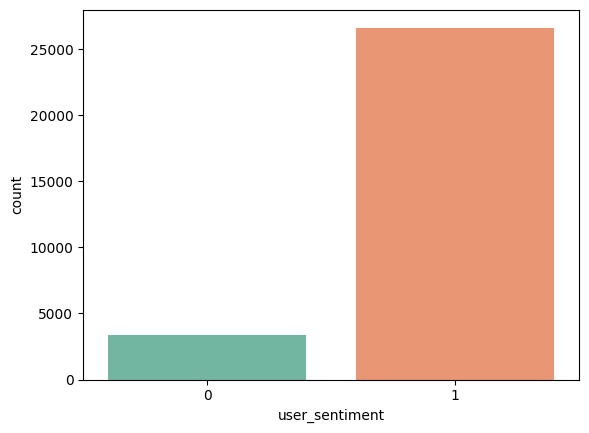

In [12]:
#Visualize using count plot
sns.countplot(x='user_sentiment', data= df_reviews, palette="Set2")

We can see overrepresentation of positive reviews. we may have to do Class Imbalance techniques during modelling.

In [13]:
df_reviews["reviews_rating"].describe()

,reviews_rating
count,29999.00
mean,4.48
std,0.99
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


In [14]:
df_reviews["reviews_rating"].value_counts()

,count
reviews_rating,
5,20830
4,6020
1,1384
3,1345
2,420


<Axes: xlabel='reviews_rating', ylabel='count'>

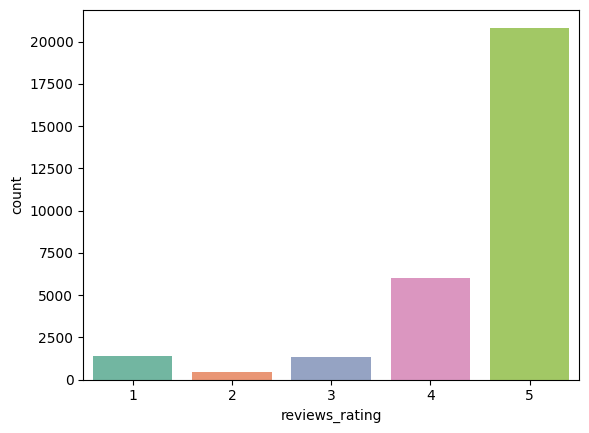

In [15]:
#visualize the user_rating..
sns.countplot(x='reviews_rating', data= df_reviews, palette="Set2")

In [16]:
df_reviews[df_reviews["user_sentiment"]==1]["reviews_rating"].describe()

,reviews_rating
count,26632.00
mean,4.56
std,0.87
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


In [17]:
df_reviews[df_reviews["user_sentiment"]==0]["reviews_rating"].describe()

,reviews_rating
count,3367.00
mean,3.87
std,1.54
min,1.00
25%,3.00
50%,5.00
75%,5.00
max,5.00


In [18]:
df_reviews[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,1
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,1
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,1
18,Pretty nice,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",3
54,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",1
...,...,...,...
29050,Didn't Do Much For Dryness,"I received this product from Influenster. I absolutely love the whole system together, it made my hair oil-free for 48 hours. But I expected the conditioner to do more for the dryness at the ends of my hair like advertised. I didn't really notice much of a different in dryness before and after I...",3
29051,Not the best,"I used this product for a month straight before reviewing it and I'm not really all that impressed. My hair still gets pretty oily, my ends are still dry.... I mean it cleaned my hair I guess. It's nothing spectacular really. It didn't make my hair extremely soft but it didn't make my hair feel ...",3
29053,clay conditioning,Got this item as a compliment from influenster but it really made my hair smooth and shining after the usage. This review was collected as part of a promotion.,3
29054,Eh,"I am not in love with the conditioner. The clay mask and shampoo are GREAT but I didn't feel like this did anything for my ends. I would buy the other two, but not this, probably because I have fine hair and my ends need deep conditioning. Smells great though! I got this product free for testing...",3


In [19]:
df_reviews[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,4
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,4
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,4
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",4
117,Not greasy,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",4
...,...,...,...
29818,Great Product,"I received a complimentary sample of this product and it worked so well for my hair! I have very thick hair so my roots always get oily and my ends are dry, this left my hair the cleanest it's felt in a long time. Will def recommend this to my family and friends! This review was collected as par...",5
29855,Great,This has prolonged the color in my hair! Not only is my hair healthier but I think I'll have to visit my stylist less! This review was collected as part of a promotion.,5
29858,Makes my hair soft and shiny without excess oil!,"This conditioner makes my hair very soft without weighing it down! I was afraid it'd make my roots more oily and weight them down, but it doesn't one bit! My hair is colored, and it hasn't faded out the color either! I'd highly recommend giving this a try! This review was collected as part of a ...",5
29862,Great Conditioner,This conditioner has become a staple in my hair regimen This review was collected as part of a promotion.,5


In [20]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,597,140,220,550,1860,3367
1,787,280,1125,5470,18970,26632
All,1384,420,1345,6020,20830,29999


As per the above results, there looks to be mismtach between review_rating and user_sentiment. there are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive. We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling. Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4

In [21]:
df_reviews.loc[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4), "user_sentiment"] = 0

In [22]:
df_reviews.loc[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4), "user_sentiment"] = 1

In [23]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1384,420,1345,0,0,3149
1,0,0,0,6020,20830,26850
All,1384,420,1345,6020,20830,29999


from the above table, we can see that we don't have mismatch between the reviews_rating and user_sentiment

In [24]:
df_reviews["user_sentiment"].value_counts()

,count
user_sentiment,
1,26850
0,3149


In [25]:
df_reviews["brand"].value_counts()

,count
brand,
Clorox,10585
Warner Home Video,3325
Disney,1199
L'oreal Paris,1186
FOX,887
...,...
Pacific Natural Foods,1
LDR,1
National Mfg.,1


In [28]:
def filter_products(productId, pos=1):
    review_count = df_reviews[(df_reviews.id==productId) & (df_reviews.user_sentiment==pos)]['brand'].count()
    return review_count

In [29]:
#group the dataframe by product id and view the # of pos review / neg reviews count
df_custom =  df_reviews.groupby('id', as_index=False)['user_sentiment'].count()
df_custom["pos_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 1))
df_custom["neg_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 0))

In [30]:
df_custom.head(10)

,id,user_sentiment,pos_review_count,neg_review_count
0,AV13O1A8GV-KLJ3akUyj,1,1,0
1,AV14LG0R-jtxr-f38QfS,2,2,0
2,AV16khLE-jtxr-f38VFn,27,10,17
3,AV1YGDqsGV-KLJ3adc-O,348,274,74
4,AV1YIch7GV-KLJ3addeG,1,1,0
5,AV1YlENIglJLPUi8IHsX,17,14,3
6,AV1YmBrdGV-KLJ3adewb,18,17,1
7,AV1YmDL9vKc47QAVgr7_,89,74,15
8,AV1Ymf_rglJLPUi8II2v,34,34,0
9,AV1Yn94nvKc47QAVgtst,25,24,1


In [31]:
#sort the product by sentiment % - postive reviews / total number of reviews
df_custom['sentiment %'] = np.round((df_custom['pos_review_count']/df_custom['user_sentiment'])*100,2)
df_custom.sort_values(by='sentiment %', ascending=False)[:20]

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
0,AV13O1A8GV-KLJ3akUyj,1,1,0,100.0
1,AV14LG0R-jtxr-f38QfS,2,2,0,100.0
4,AV1YIch7GV-KLJ3addeG,1,1,0,100.0
8,AV1Ymf_rglJLPUi8II2v,34,34,0,100.0
11,AV1Ynb3bglJLPUi8IJxJ,5,5,0,100.0
13,AV1Yo6FPglJLPUi8IK3u,1,1,0,100.0
10,AV1YnUMYglJLPUi8IJpK,1,1,0,100.0
247,AVpfml2VilAPnD_xe0m6,1,1,0,100.0
245,AVpfmVnVLJeJML43AMqC,6,6,0,100.0
45,AVpe5Mv4ilAPnD_xQQyy,4,4,0,100.0


In [32]:
df_reviews["manufacturer"].value_counts()

,count
manufacturer,
Clorox,8546
Test,3325
AmazonUs/CLOO7,2039
L'oreal Paris,1232
Walt Disney,1142
...,...
Unfi,1
LDR,1
Stanley Hardware,1


In [33]:
#Let's find out the most common users.
df_reviews["reviews_username"].value_counts()[:10]

,count
reviews_username,
mike,41
byamazon customer,41
chris,32
lisa,16
tony,15
sandy,15
rick,15
john,14
dave,14


In [36]:
#removing nan/null from username
df_reviews = df_reviews[~df_reviews.reviews_username.isnull()]

In [37]:
#Let's combine the reviews_text and reviews_title for better analysis
df_reviews["reviews_title"] = df_reviews["reviews_title"].fillna('')
df_reviews["reviews_full_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [38]:
#get the missing row cout for each of the columns
calcMissingRowCount(df_reviews)

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,40
reviews_didPurchase,14005
reviews_doRecommend,2541
reviews_rating,0
reviews_text,0


Required columns for reviews_rating, reviews_text, user_sentiment,reviews_username doesn't have null/na values

### 4. Text Preprocessing for Deeplearning Modelling

In [39]:
import string

In [40]:
df_reviews[["reviews_full_text", "user_sentiment"]].sample(10)

,reviews_full_text,user_sentiment
15505,Love this item!!. I love this Puffcorn...other stores do not always have it but I have learned to rely on Walmart to always have it stocked!!,1
12525,Quickly Easily cleans up your mess. Excellent Product - cleans up your Mess quick and easily This review was collected as part of a promotion.,1
911,Amazing Product with Many uses!!. Windex is a great common household product I myself like the refill bottle because it is almost the same price of the bottle and is 2x the size!! Love Love Love Windex also it was a cinch to pick it up in Store!!,1
11262,Works like a charm. Things really feel clean after using these wipes. Very easy to use and handy to have around. This review was collected as part of a promotion.,1
12455,Clorox Cleans. Great germ killer to keep my countertops sparkling clean! This review was collected as part of a promotion.,1
6583,Hiiii. love it so much. i would recomend it to everyone This review was collected as part of a promotion.,1
4734,Good price!. No complaints here! Awesome bundle for cheap! Can't find better deals!,1
7431,toys. Great product! I love using it to clean my son's toys. This review was collected as part of a promotion.,1
21700,You Changed The Formula!. Unfortunately you lost a loyal customer. I have used this product for over 10 years. It was the only product that worked with my hair. Very unhappy that you changed an awesome product. Very unhappy,0
1104,Good. Enjoyed it,1


In [41]:
'''function to clean the text and remove all the unnecessary elements.'''
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'http\S+', '', text)  # Remove URLs

    return text

In [42]:
df_clean = df_reviews[['id','name', 'reviews_full_text', 'user_sentiment']]

In [43]:
df_clean["reviews_text"] = df_clean.reviews_full_text.apply(lambda x: clean_text(x))

In [44]:
df_clean.head()

,id,name,reviews_full_text,user_sentiment,reviews_text
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,1,just awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected as part of a promotion.,1,good. good flavor. this review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1,good. good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation...",0,"disappointed. i read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews i had read. for starters, neither my boyfriend nor i could notice any sort of enhanced or 'captivating' sensation..."
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0,irritation. my husband bought this gel for us. the gel caused irritation and it felt like it was burning my skin. i wouldn't recommend this gel.


# LSTM Model from scratch

In [93]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_clean["reviews_text"])

sequences = tokenizer.texts_to_sequences(df_clean["reviews_text"])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')


In [94]:
# Split into Train/Test Sets

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df_clean['user_sentiment'].values, test_size=0.2, random_state=42
)

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [96]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [97]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.8899 - loss: 0.3601 - val_accuracy: 0.8891 - val_loss: 0.3473
Epoch 2/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 137s 140ms/step - accuracy: 0.8941 - loss: 0.3443 - val_accuracy: 0.8896 - val_loss: 0.3473
Epoch 3/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 144s 144ms/step - accuracy: 0.9014 - loss: 0.3274 - val_accuracy: 0.8896 - val_loss: 0.3481
Epoch 4/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 144s 147ms/step - accuracy: 0.9001 - loss: 0.3302 - val_accuracy: 0.8898 - val_loss: 0.3473
Epoch 5/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 137s 139ms/step - accuracy: 0.9007 - loss: 0.3284 - val_accuracy: 0.8896 - val_loss: 0.3472


In [98]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

f1 = f1_score(y_test, y_pred)
accuracy_score = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.2f}")
print(f"Accuracy Score: {accuracy_score:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC Score: {auc:.2f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
F1 Score: 0.95
Accuracy Score: 0.90
Precision: 0.90
Recall: 1.00
AUC Score: 0.53


# LSTM model based on word2vect embedding

Train a Word2Vec model, build and train an LSTM model using the Word2Vec embeddings, and evaluate the LSTM model using F1 score, Precision, Recall, and DOC score.

Train a Word2Vec model on the text data.


**Reasoning**:
Import the Word2Vec class and train a Word2Vec model on the tokenized text data from `df_clean["reviews_text"]`.



In [99]:
%pip install gensim

In [104]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the text data
tokenized_reviews = [word_tokenize(text) for text in df_clean["reviews_text"]]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

## Create Embedding Layer

Create an embedding layer using the trained Word2Vec model.

**Reasoning**:
Create a weight matrix for the embedding layer using the Word2Vec model's vocabulary and vectors. Then, define an Embedding layer in Keras, initializing it with this weight matrix and setting `trainable` to False to use the pre-trained embeddings.

In [105]:
import numpy as np
from tensorflow.keras.layers import Embedding

# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Create the embedding layer
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)

## Build and Compile the LSTM Model

Build an LSTM model using the Word2Vec embedding layer and compile it.

**Reasoning**:
Define a Sequential model in Keras, adding the pre-trained Word2Vec embedding layer, followed by an LSTM layer and a Dense output layer. Compile the model using binary crossentropy loss and the Adam optimizer.

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_w2v = Sequential([
    embedding_layer,
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the LSTM Model

Train the LSTM model on the training data.

**Reasoning**:
Train the `model_w2v` using the training data (`X_train` and `y_train`).

In [107]:
history_w2v = model_w2v.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.8693 - loss: 0.4059 - val_accuracy: 0.8873 - val_loss: 0.3459
Epoch 2/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.8955 - loss: 0.3371 - val_accuracy: 0.8883 - val_loss: 0.3440
Epoch 3/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - accuracy: 0.8969 - loss: 0.3222 - val_accuracy: 0.8894 - val_loss: 0.3361
Epoch 4/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 79s 103ms/step - accuracy: 0.8965 - loss: 0.3107 - val_accuracy: 0.8883 - val_loss: 0.3487
Epoch 5/5
599/599 ━━━━━━━━━━━━━━━━━━━━ 70s 117ms/step - accuracy: 0.8970 - loss: 0.3333 - val_accuracy: 0.9180 - val_loss: 0.2620


## Evaluate the LSTM Model

Evaluate the trained LSTM model on the test data using relevant metrics.

**Reasoning**:
Predict the sentiment on the test data using the trained `model_w2v`. Calculate and print the F1 score, precision, recall, and AUC score.

In [108]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

y_pred_proba_w2v = model_w2v.predict(X_test)
y_pred_w2v = (y_pred_proba_w2v > 0.5).astype("int32")

f1_w2v = f1_score(y_test, y_pred_w2v)
accuracy_score_w2v = accuracy_score(y_test, y_pred_w2v)
precision_w2v = precision_score(y_test, y_pred_w2v)
recall_w2v = recall_score(y_test, y_pred_w2v)
auc_w2v = roc_auc_score(y_test, y_pred_proba_w2v)

print(f"F1 Score (Word2Vec LSTM): {f1_w2v:.2f}")
print(f"Accuracy Score (Word2Vec LSTM): {accuracy_score_w2v:.2f}")
print(f"Precision (Word2Vec LSTM): {precision_w2v:.2f}")
print(f"Recall (Word2Vec LSTM): {recall_w2v:.2f}")
print(f"AUC Score (Word2Vec LSTM): {auc_w2v:.2f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step
F1 Score (Word2Vec LSTM): 0.96
Accuracy Score (Word2Vec LSTM): 0.92
Precision (Word2Vec LSTM): 0.93
Recall (Word2Vec LSTM): 0.98
AUC Score (Word2Vec LSTM): 0.82


## Fine-tuned BERT Model

**Reasoning**:
Install the required libraries for fine-tuning a BERT model.



In [45]:
%pip install transformers
%pip install tensorflow_text

## Load and preprocess data for bert


Load the dataset and preprocess the text data specifically for BERT input.


**Reasoning**:
Import necessary modules, instantiate the tokenizer, tokenize the text data, and prepare the sentiment labels for BERT input.



## Build the BERT model

Load a pre-trained BERT model and add a classification layer for sentiment analysis.

**Reasoning**:
Load a pre-trained `TFBertForSequenceClassification` model from the `transformers` library, specifying the number of output labels (2 for binary sentiment).

In [45]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [46]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [48]:
from transformers import BertTokenizer
import tensorflow as tf

# Instantiate the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the text data
tokenized_texts = [tokenizer.tokenize(sent) for sent in df_clean['reviews_full_text']]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['just', 'awesome', '.', 'i', 'love', 'this', 'album', '.', 'it', "'", 's', 'very', 'good', '.', 'more', 'to', 'the', 'hip', 'hop', 'side', 'than', 'her', 'current', 'pop', 'sound', '.', '.', 'so', 'h', '##ype', '!', 'i', 'listen', 'to', 'this', 'everyday', 'at', 'the', 'gym', '!', 'i', 'give', 'it', '5', '##star', 'rating', 'all', 'the', 'way', '.', 'her', 'metaphor', '##s', 'are', 'just', 'crazy', '.']


In [49]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Extract input IDs and attention masks
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)



In [63]:

# Prepare sentiment labels
labels = df_clean['user_sentiment'].values
print(labels.size)

29936


In [ ]:

# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [56]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [57]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [58]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:27<00:00, 14863440.23B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [59]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [60]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [61]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [62]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.17847595351135398


Epoch:  25%|██▌       | 1/4 [11:41<35:04, 701.35s/it]

Validation Accuracy: 0.9507978723404256
Train loss: 0.11709644308871194


Epoch:  50%|█████     | 2/4 [23:18<23:18, 699.01s/it]

Validation Accuracy: 0.9561170212765957
Train loss: 0.08911776313814833


Epoch:  75%|███████▌  | 3/4 [34:55<11:37, 697.93s/it]

Validation Accuracy: 0.9534574468085106
Train loss: 0.0699408850422452


Epoch: 100%|██████████| 4/4 [46:31<00:00, 697.99s/it]

Validation Accuracy: 0.9541223404255319


In [64]:
 print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Validation Accuracy: 0.9541223404255319


# Overall performance of various sentiment models

| Metric     | Logistic Regression | Naive Bayes | Random Forest | XGBoost | LSTM (Scratch) | LSTM (Word2Vec) | BERT   |
|------------|---------------------|-------------|----------------|--------|----------------|------------------|--------|
| Accuracy   | 0.88                | 0.81        | 0.80           | 0.91   | 0.90           | 0.92             | 0.955  |
| Precision  | 0.97                | 0.98        | 0.96           | 0.96   | 0.90           | 0.93             | NA     |
| Recall     | 0.90                | 0.81        | 0.81           | 0.94   | 1.00           | 0.98             | NA     |
| F1 Score   | 0.93                | 0.89        | 0.88           | 0.95   | 0.95           | 0.96             | NA     |
| AUC Score  | 0.90                | 0.90        | 0.86           | 0.91   | 0.53           | 0.82             | NA     |
